In [72]:
# %% Initialize

import numpy as np
import matplotlib.pyplot as plt
import pickle


# own class
from Algorithms import Bregman_SoR, NASA_SoR, SCSC_SoR

# plot setting
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "ps.usedistiller": "xpdf"})


In [73]:
oracles = 90000  # total oracles to samples
batch_list = [100]  # , 100]
number_experiment = 20  # number of repeated experiment


# Dh
BG_Dh, SCSC_Dh, NASA_Dh = [
    np.zeros([number_experiment, 900, len(batch_list)]) for _ in range(3)]
BG_Dh_avg, SCSC_Dh_avg, NASA_Dh_avg = [
    np.zeros([number_experiment, 900, len(batch_list)]) for _ in range(3)]

# determinastic gradient
BG_gradF_det, SCSC_gradF_det, NASA_gradF_det = [
    np.zeros([number_experiment, 900, len(batch_list)]) for _ in range(3)]
BG_gradF_det_avg, SCSC_gradF_det_avg, NASA_gradF_det_avg = [
    np.zeros([number_experiment, 900, len(batch_list)]) for _ in range(3)]

# function values
BG_Fval, SCSC_Fval, NASA_Fval = [
    np.zeros([number_experiment, 900, len(batch_list)]) for _ in range(3)]
BG_Fval_avg, SCSC_Fval_avg, NASA_Fval_avg = [
    np.zeros([number_experiment, 900, len(batch_list)]) for _ in range(3)]

# read data
folder = f'Results/exp_algs_compare/'
#folder = f'Results/noise1/'
k1, k2 = 15.84, 6.31e-3
for idx_batch in range(len(batch_list)):
    max_iter = oracles // batch_list[idx_batch]
    for idx_exp in range(number_experiment):

        with open(folder + f'Breg_batch{batch_list[idx_batch]}_exp{idx_exp}.pickle', 'rb') as file:
            BG_exp = pickle.load(file)
        BG_Fval[idx_exp, 0:max_iter, idx_batch] = BG_exp.val_F_traj
        BG_Fval_avg[idx_exp, 0:max_iter, idx_batch] = BG_exp.val_F_avg_traj

        BG_Dh_avg[idx_exp, 0:max_iter, idx_batch] = k1 * \
            BG_exp.Dh1_avg_traj + k2 * BG_exp.Dh2_avg_traj
        BG_Dh[idx_exp, 0:max_iter, idx_batch] = k1 * \
            BG_exp.Dh1_traj + k2 * BG_exp.Dh2_traj

        BG_gradF_det[idx_exp, 0:max_iter,
                     idx_batch] = BG_exp.norm_gradFdet_traj
        BG_gradF_det_avg[idx_exp, 0:max_iter,
                         idx_batch] = BG_exp.norm_gradFdet_avg_traj

        with open(folder + f'SCSC_batch{batch_list[idx_batch]}_exp{idx_exp}.pickle', 'rb') as file:
            SCSC_exp = pickle.load(file)
        SCSC_Fval[idx_exp, 0:max_iter, idx_batch] = SCSC_exp.val_F_traj
        SCSC_Fval_avg[idx_exp, 0:max_iter, idx_batch] = SCSC_exp.val_F_avg_traj

        SCSC_Dh_avg[idx_exp, 0:max_iter, idx_batch] = k1 * \
            SCSC_exp.Dh1_avg_traj + k2 * SCSC_exp.Dh2_avg_traj
        SCSC_Dh[idx_exp, 0:max_iter, idx_batch] = k1 * \
            SCSC_exp.Dh1_traj + k2 * SCSC_exp.Dh2_traj

        SCSC_gradF_det[idx_exp, 0:max_iter,
                       idx_batch] = SCSC_exp.norm_gradFdet_traj
        SCSC_gradF_det_avg[idx_exp, 0:max_iter,
                           idx_batch] = SCSC_exp.norm_gradFdet_avg_traj

        with open(folder + f'NASA_batch{batch_list[idx_batch]}_exp{idx_exp}.pickle', 'rb') as file:
            NASA_exp = pickle.load(file)
        NASA_Fval[idx_exp, 0:max_iter, idx_batch] = NASA_exp.val_F_traj
        NASA_Fval_avg[idx_exp, 0:max_iter, idx_batch] = NASA_exp.val_F_avg_traj

        NASA_Dh_avg[idx_exp, 0:max_iter, idx_batch] = k1 * \
            NASA_exp.Dh1_avg_traj + k2 * NASA_exp.Dh2_avg_traj
        NASA_Dh[idx_exp, 0:max_iter, idx_batch] = k1 * \
            NASA_exp.Dh1_traj + k2 * NASA_exp.Dh2_traj

        NASA_gradF_det[idx_exp, 0:max_iter,
                       idx_batch] = NASA_exp.norm_gradFdet_traj
        NASA_gradF_det_avg[idx_exp, 0:max_iter,
                           idx_batch] = NASA_exp.norm_gradFdet_avg_traj


In [74]:


def plot_line(xrange, data, ax, **kwargs):
    # plot each experiment and their average
    # array shape n x L, where n is the number of experiment, L is the length of one experiment

    color, label, marker, markevery = kwargs.get('color'), kwargs.get(
        'label'), kwargs.get('marker'), kwargs.get('markevery')
    linestyle = kwargs.get('linestyle')
    alpha = kwargs.get('alpha', 0.1)

    data_mean = np.mean(data, axis=0)

    ax.plot(xrange, data_mean, color=color, label=label,
            marker=marker, markevery=markevery, linestyle=linestyle)
    for idx in range(data.shape[0]):
        ax.fill_between(xrange,
                        data[idx, :], data_mean, color=color, alpha=alpha)


kwargs_plot = {'BG': {'color': 'C0', 'marker': 'o', 'markevery': 50, 'label': 'SoR'},
               'NASA': {'color': 'C1', 'marker': 's', 'markevery': 60, 'label': 'NASA'},
               'SCSC': {'color': 'C2', 'marker': 'v', 'markevery': 70, 'label': 'SCSC'},
               'fill': {'alpha': 0.01},
               'batch900': {'color': 'C0', 'linestyle': 'solid', 'label': r"$|\mathcal{B}_{\nabla}| = 900$"},
               'batch100': {'color': 'C1', 'linestyle': 'dotted', 'label': r"$|\mathcal{B}_{\nabla}| = 100$"},
               'batch50': {'color': 'C2', 'linestyle': 'dashed', 'label': r"$|\mathcal{B}_{\nabla}| = 50$"}
               }


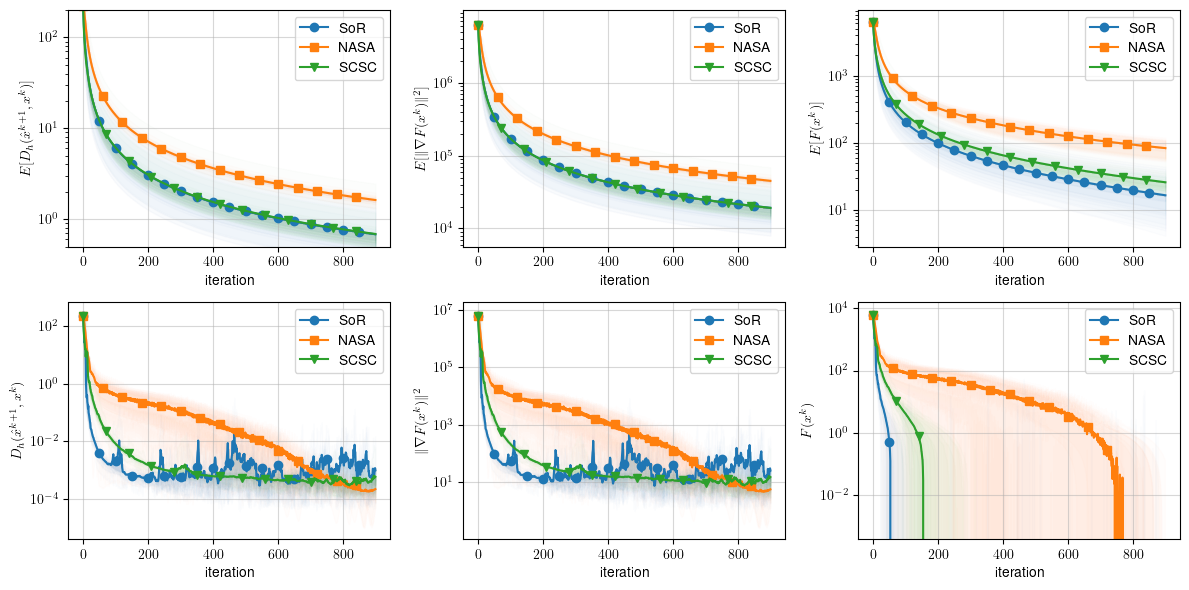

In [78]:
# plot

for idx_batch in range(1):
    fig, axs = plt.subplots(2, 3, figsize=(12, 6))

    max_iter = oracles // batch_list[idx_batch]
    max_iter = 900

# Dh
    ax = axs[0, 0]
    plot_line(np.arange(max_iter), BG_Dh_avg[:, 0:max_iter,
              idx_batch], ax, **kwargs_plot['BG'] | kwargs_plot['fill'])
    plot_line(np.arange(max_iter), NASA_Dh_avg[:, 0:max_iter,
              idx_batch], ax, **kwargs_plot['NASA'] | kwargs_plot['fill'])
    plot_line(np.arange(max_iter), SCSC_Dh_avg[:, 0:max_iter,
              idx_batch], ax, **kwargs_plot['SCSC'] | kwargs_plot['fill'])
    ax.set_ylabel(r"$E[D_{h}(\hat{x}^{k+1}, x^k)]$")
    ax.set_ylim([0.5, 2e2])
    ax.legend()

    ax = axs[1, 0]
    plot_line(np.arange(max_iter), BG_Dh[:, 0:max_iter, idx_batch],
              ax, **kwargs_plot['BG'] | kwargs_plot['fill'])
    plot_line(np.arange(max_iter), NASA_Dh[:, 0:max_iter, idx_batch],
              ax, **kwargs_plot['NASA'] | kwargs_plot['fill'])
    plot_line(np.arange(max_iter), SCSC_Dh[:, 0:max_iter, idx_batch],
              ax, **kwargs_plot['SCSC'] | kwargs_plot['fill'])
    ax.set_ylabel(r"$D_{h}(\hat{x}^{k+1}, x^k)$")
    ax.legend()

# norm of gradient
    ax = axs[0, 1]
    plot_line(np.arange(max_iter), BG_gradF_det_avg[:, 0:max_iter,
              idx_batch], ax, **kwargs_plot['BG'] | kwargs_plot['fill'])
    plot_line(np.arange(max_iter), NASA_gradF_det_avg[:, 0:max_iter,
              idx_batch], ax, **kwargs_plot['NASA'] | kwargs_plot['fill'])
    plot_line(np.arange(max_iter), SCSC_gradF_det_avg[:, 0:max_iter,
              idx_batch], ax, **kwargs_plot['SCSC'] | kwargs_plot['fill'])
    ax.legend()
    ax.set_ylabel(r"$E[\|\nabla F(x^k)\|^2]$")

    ax = axs[1, 1]
    plot_line(np.arange(max_iter), BG_gradF_det[:, 0:max_iter,
              idx_batch], ax, **kwargs_plot['BG'] | kwargs_plot['fill'])
    plot_line(np.arange(max_iter), NASA_gradF_det[:, 0:max_iter,
              idx_batch], ax, **kwargs_plot['NASA'] | kwargs_plot['fill'])
    plot_line(np.arange(max_iter), SCSC_gradF_det[:, 0:max_iter,
              idx_batch], ax, **kwargs_plot['SCSC'] | kwargs_plot['fill'])
    ax.legend()
    ax.set_ylabel(r"$\|\nabla F(x^k)\|^2$")

    # function values
    ax = axs[0, 2]
    plot_line(np.arange(max_iter), BG_Fval_avg[:, 0:max_iter, idx_batch], ax, **
              kwargs_plot['BG'] | kwargs_plot['fill'])
    plot_line(np.arange(max_iter), NASA_Fval_avg[:, 0:max_iter, idx_batch], ax, **
              kwargs_plot['NASA'] | kwargs_plot['fill'])
    plot_line(np.arange(max_iter), SCSC_Fval_avg[:, 0:max_iter, idx_batch], ax, **
              kwargs_plot['SCSC'] | kwargs_plot['fill'])
    ax.legend()
    ax.set_ylabel(r"$E[F(x^k)]$")

    ax = axs[1, 2]
    plot_line(np.arange(max_iter), BG_Fval[:, 0:max_iter, idx_batch], ax, **
              kwargs_plot['BG'] | kwargs_plot['fill'])
    plot_line(np.arange(max_iter), NASA_Fval[:, 0:max_iter, idx_batch], ax, **
              kwargs_plot['NASA'] | kwargs_plot['fill'])
    plot_line(np.arange(max_iter), SCSC_Fval[:, 0:max_iter, idx_batch], ax, **
              kwargs_plot['SCSC'] | kwargs_plot['fill'])
    ax.legend()
    ax.set_ylabel(r"$F(x^k)$")

    for ax in axs.flat:
        ax.set_xlabel("iteration")
        ax.set_yscale("log")
        ax.grid(True, alpha=0.5)
    fig.tight_layout()

    #filename = f"Plots/Compare_batch{batch_list[idx_batch]}.pdf"
    # plt.savefig(filename)
    # plt.close()


Save the figures

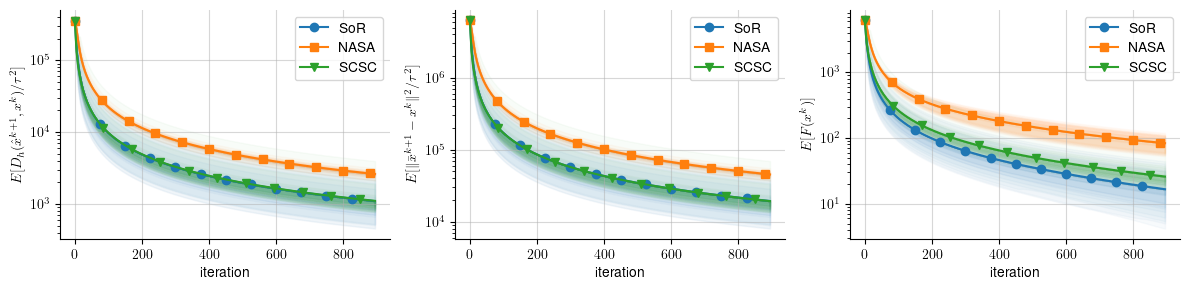

In [107]:
kwargs_plot = {'BG': {'color': 'C0', 'marker': 'o', 'markevery': 15, 'label': 'SoR'},
               'NASA': {'color': 'C1', 'marker': 's', 'markevery': 16, 'label': 'NASA'},
               'SCSC': {'color': 'C2', 'marker': 'v', 'markevery': 17, 'label': 'SCSC'},
               'fill': {'alpha': 0.03},
               'batch900': {'color': 'C0', 'linestyle': 'solid', 'label': r"$|\mathcal{B}_{\nabla}| = 900$"},
               'batch100': {'color': 'C1', 'linestyle': 'dotted', 'label': r"$|\mathcal{B}_{\nabla}| = 100$"},
               'batch50': {'color': 'C2', 'linestyle': 'dashed', 'label': r"$|\mathcal{B}_{\nabla}| = 50$"}
               }

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
max_iter = 900

# Dh
ax = axs[0]
plot_line(np.arange(0, max_iter, 5),
          BG_Dh_avg[:, 0:max_iter:5, idx_batch]/0.025**2, ax, **kwargs_plot['BG'] | kwargs_plot['fill'])
plot_line(np.arange(0, max_iter, 5),
          NASA_Dh_avg[:, 0:max_iter:5, idx_batch]/0.025**2, ax, **kwargs_plot['NASA'] | kwargs_plot['fill'])
plot_line(np.arange(0, max_iter, 5),
          SCSC_Dh_avg[:, 0:max_iter:5, idx_batch]/0.025**2, ax, **kwargs_plot['SCSC'] | kwargs_plot['fill'])
ax.set_ylabel(r"$E[D_{h}(\hat{x}^{k+1}, x^k)/\tau^2]$")
# ax.set_ylim([0.5,3e2])


# norm of gradient
ax = axs[1]
plot_line(np.arange(0, max_iter, 5),
          BG_gradF_det_avg[:, 0:max_iter:5, idx_batch], ax, **kwargs_plot['BG'] | kwargs_plot['fill'])
plot_line(np.arange(0, max_iter, 5),
          NASA_gradF_det_avg[:, 0:max_iter:5, idx_batch], ax, **kwargs_plot['NASA'] | kwargs_plot['fill'])
plot_line(np.arange(0, max_iter, 5),
          SCSC_gradF_det_avg[:, 0:max_iter:5, idx_batch], ax, **kwargs_plot['SCSC'] | kwargs_plot['fill'])
ax.legend()
ax.set_ylabel(r"$E[\|\bar{x}^{k+1} - x^k\|^2/\tau^2]$")

ax = axs[2]
plot_line(np.arange(0, max_iter, 5), BG_Fval_avg[:, 0:max_iter:5, idx_batch], ax, **
          kwargs_plot['BG'] | kwargs_plot['fill'])
plot_line(np.arange(0, max_iter, 5), NASA_Fval_avg[:, 0:max_iter:5, idx_batch], ax, **
          kwargs_plot['NASA'] | kwargs_plot['fill'])
plot_line(np.arange(0, max_iter, 5), SCSC_Fval_avg[:, 0:max_iter:5, idx_batch], ax, **
          kwargs_plot['SCSC'] | kwargs_plot['fill'])
ax.set_ylabel(r"$E[F(x^k)]$")

for ax in axs.flat:
    ax.set_xlabel("iteration")
    ax.set_yscale("log")
    ax.grid(True, alpha=0.5)
    ax.legend()
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
fig.tight_layout()
fig.savefig('Plots/SoR_algs_compare.pdf', bbox_inches='tight')


# plot different batch sizes of Breg

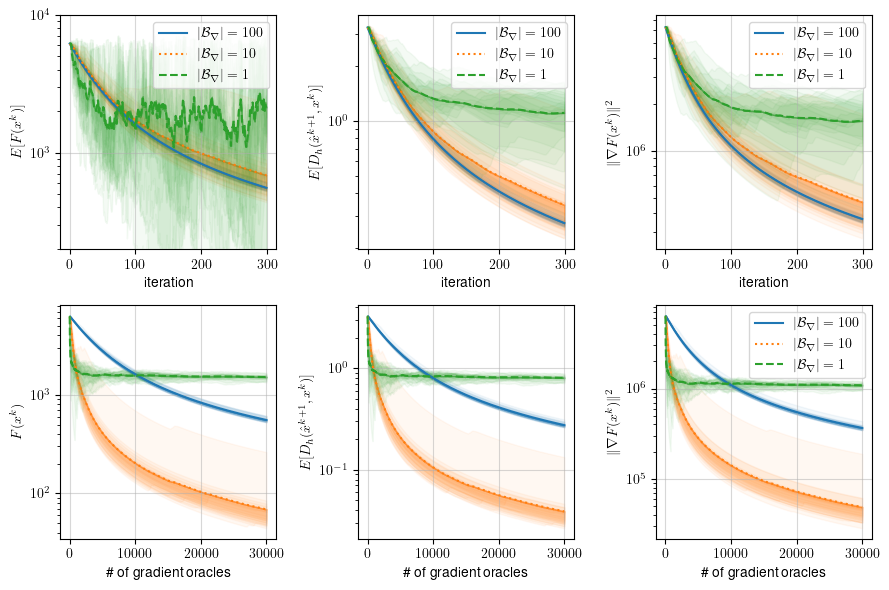

In [108]:
kwargs_plot = {'BG': {'color': 'C0', 'marker': 'o', 'markevery': 50, 'label': 'SoR'},
               'NASA': {'color': 'C1', 'marker': 's', 'markevery': 60, 'label': 'NASA'},
               'SCSC': {'color': 'C2', 'marker': 'v', 'markevery': 70, 'label': 'SCSC'},
               'fill': {'alpha': 0.05},
               'batch100': {'color': 'C0', 'linestyle': 'solid', 'label': r"$|\mathcal{B}_{\nabla}| = 100$"},
               'batch10': {'color': 'C1', 'linestyle': 'dotted', 'label': r"$|\mathcal{B}_{\nabla}| = 10$"},
               'batch1': {'color': 'C2', 'linestyle': 'dashed', 'label': r"$|\mathcal{B}_{\nabla}| = 1$"}
               }
batch_list = [100, 10, 1]
number_experiment = 20  # number of repeated experiment
oracles = 100*300
k1, k2 = 0.5, 2.16
# Dh
BG_Dh = np.zeros([number_experiment, 30000, len(batch_list)])
BG_Dh_avg = np.zeros([number_experiment, 30000, len(batch_list)])

# determinastic gradient
BG_gradF_det = np.zeros([number_experiment, 30000, len(batch_list)])
BG_gradF_det_avg = np.zeros([number_experiment, 30000, len(batch_list)])

# function values
BG_Fval = np.zeros([number_experiment, 30000, len(batch_list)])
BG_Fval_avg = np.zeros([number_experiment, 30000, len(batch_list)])

# read data
folder = f'Results/exp_batch_compare/'
#k1, k2 = 10, 1.58e-3
for idx_batch in range(len(batch_list)):
    max_iter = oracles // batch_list[idx_batch]
    for idx_exp in range(number_experiment):

        with open(folder + f'Breg_batch{batch_list[idx_batch]}_exp{idx_exp}.pickle', 'rb') as file:
            BG_exp = pickle.load(file)
        BG_Fval[idx_exp, 0:max_iter, idx_batch] = BG_exp.val_F_traj
        BG_Fval_avg[idx_exp, 0:max_iter, idx_batch] = BG_exp.val_F_avg_traj

        BG_Dh_avg[idx_exp, 0:max_iter, idx_batch] = k1 * \
            BG_exp.Dh1_avg_traj + k2 * BG_exp.Dh2_avg_traj
        BG_Dh[idx_exp, 0:max_iter, idx_batch] = k1 * \
            BG_exp.Dh1_traj + k2 * BG_exp.Dh2_traj

        BG_gradF_det[idx_exp, 0:max_iter,
                     idx_batch] = BG_exp.norm_gradFdet_traj
        BG_gradF_det_avg[idx_exp, 0:max_iter,
                         idx_batch] = BG_exp.norm_gradFdet_avg_traj


# plot Bregman method for different batches

fig, axs = plt.subplots(2, 3, figsize=(9, 6))

# function values
ax = axs[0, 0]
plot_line(np.arange(0, 300), BG_Fval_avg[:, 0:300, 0], ax, **
          kwargs_plot['batch100'] | kwargs_plot['fill'])
plot_line(np.arange(0, 300), BG_Fval_avg[:, 0:300, 1], ax, **
          kwargs_plot['batch10'] | kwargs_plot['fill'])
plot_line(np.arange(0, 300), BG_Fval[:, 0:300, 2], ax, **
          kwargs_plot['batch1'] | kwargs_plot['fill'])
ax.legend()
ax.set_ylim([2e2, 1e4])
ax.set_xlabel("iteration")
ax.set_ylabel(r"$E[F(x^k)]$")

ax = axs[1, 0]
plot_line(np.arange(100, 30100, 100), BG_Fval_avg[:, 0:300, 0], ax, **
          kwargs_plot['batch100'] | kwargs_plot['fill'])
plot_line(np.arange(10, 30010, 10), BG_Fval_avg[:, 0:3000, 1], ax, **
          kwargs_plot['batch10'] | kwargs_plot['fill'])
plot_line(np.arange(1, 30001, 1), BG_Fval_avg[:, 0:30000, 2], ax, **
          kwargs_plot['batch1'] | kwargs_plot['fill'])
ax.set_xlabel("\# of gradient oracles ")
ax.set_ylabel(r"$F(x^k)$")


# Dh+Dh2
ax = axs[0, 1]
plot_line(np.arange(0, 300), BG_Dh_avg[:, 0:300, 0], ax, **
          kwargs_plot['batch100'] | kwargs_plot['fill'])
plot_line(np.arange(0, 300), BG_Dh_avg[:, 0:300, 1], ax, **
          kwargs_plot['batch10'] | kwargs_plot['fill'])
plot_line(np.arange(0, 300), BG_Dh_avg[:, 0:300, 2], ax, **
          kwargs_plot['batch1'] | kwargs_plot['fill'])
ax.set_xlabel("iteration")
ax.set_ylabel(r"$E[D_{h}(\hat{x}^{k+1}, x^k)]$")
ax.legend()

ax = axs[1, 1]
plot_line(np.arange(100, 30100, 100), BG_Dh_avg[:, 0:300, 0], ax, **
          kwargs_plot['batch100'] | kwargs_plot['fill'])
plot_line(np.arange(10, 30010, 10), BG_Dh_avg[:, 0:3000, 1], ax, **
          kwargs_plot['batch10'] | kwargs_plot['fill'])
plot_line(np.arange(1, 30001, 1), BG_Dh_avg[:, 0:30000, 2], ax, **
          kwargs_plot['batch1'] | kwargs_plot['fill'])
ax.set_xlabel("\# of gradient oracles ")
ax.set_ylabel(r"$E[D_{h}(\hat{x}^{k+1}, x^k)]$")

# # norm grad Fdet
ax = axs[0, 2]
plot_line(np.arange(0, 300), BG_gradF_det_avg[:, 0:300, 0], ax,
          **kwargs_plot['batch100'] | kwargs_plot['fill'])
plot_line(np.arange(0, 300), BG_gradF_det_avg[:, 0:300, 1], ax,
          **kwargs_plot['batch10'] | kwargs_plot['fill'])
plot_line(np.arange(0, 300), BG_gradF_det_avg[:, 0:300, 2], ax,
          **kwargs_plot['batch1'] | kwargs_plot['fill'])
ax.legend()
ax.set_xlabel("iteration")
ax.set_ylabel(r"$\|\nabla F(x^k)\|^2$")

ax = axs[1, 2]
plot_line(np.arange(100, 30100, 100), BG_gradF_det_avg[:, 0:300, 0], ax,
          **kwargs_plot['batch100'] | kwargs_plot['fill'])
plot_line(np.arange(10, 30010, 10), BG_gradF_det_avg[:, 0:3000, 1], ax,
          **kwargs_plot['batch10'] | kwargs_plot['fill'])
plot_line(np.arange(1, 30001, 1), BG_gradF_det_avg[:, 0:30000, 2], ax,
          **kwargs_plot['batch1'] | kwargs_plot['fill'])
ax.legend()
ax.set_xlabel("\# of gradient oracles ")
ax.set_ylabel(r"$\|\nabla F(x^k)\|^2$")


for ax in axs.flat:
    ax.set_yscale("log")
    ax.grid(True, alpha=0.5)
fig.tight_layout()

# filename = f"Plots/Compare_batch{batch_list[idx_batch]}.pdf"
# plt.savefig(filename)
# plt.close()


save figures
use index to reduce the size of output files

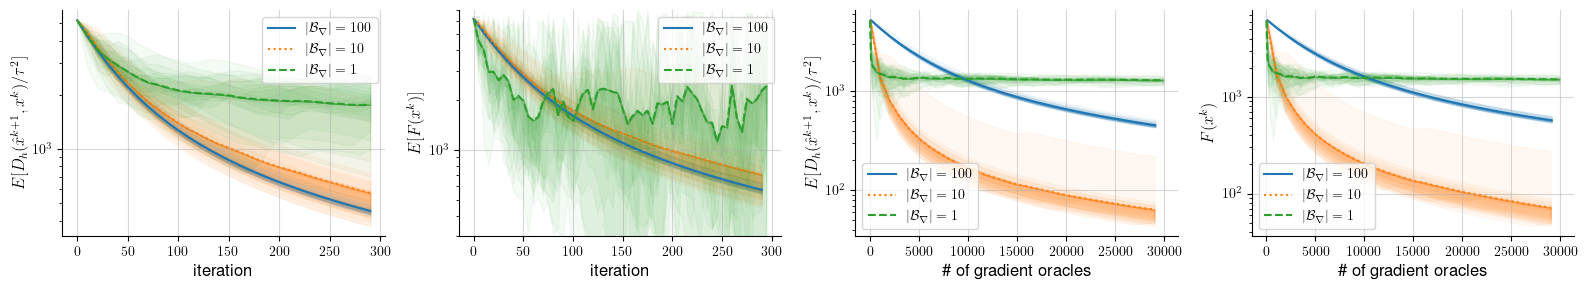

In [138]:
kwargs_plot = {'BG': {'color': 'C0', 'marker': 'o', 'markevery': 50, 'label': 'SoR'},
               'NASA': {'color': 'C1', 'marker': 's', 'markevery': 60, 'label': 'NASA'},
               'SCSC': {'color': 'C2', 'marker': 'v', 'markevery': 70, 'label': 'SCSC'},
               'fill': {'alpha': 0.05},
               'batch100': {'color': 'C0', 'linestyle': 'solid', 'label': r"$|\mathcal{B}_{\nabla}| = 100$"},
               'batch10': {'color': 'C1', 'linestyle': 'dotted', 'label': r"$|\mathcal{B}_{\nabla}| = 10$"},
               'batch1': {'color': 'C2', 'linestyle': 'dashed', 'label': r"$|\mathcal{B}_{\nabla}| = 1$"}
               }
batch_list = [100, 10, 1]
number_experiment = 20  # number of repeated experiment
oracles = 100*300
k1, k2 = 0.5, 2.16


# plot Bregman method for different batches

fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Dh
ax = axs[0]
plot_line(np.arange(0, 300, 10), BG_Dh_avg[:, 0:300:10, 0] / 0.025**2, ax, **
          kwargs_plot['batch100'] | kwargs_plot['fill'])
plot_line(np.arange(0, 300, 10), BG_Dh_avg[:, 0:300:10, 1] / 0.025**2, ax, **
          kwargs_plot['batch10'] | kwargs_plot['fill'])
plot_line(np.arange(0, 300, 10), BG_Dh_avg[:, 0:300:10, 2] / 0.025**2, ax, **
          kwargs_plot['batch1'] | kwargs_plot['fill'])
ax.set_xlabel("iteration", fontsize=12)
ax.set_ylabel(r"$E[D_{h}(\hat{x}^{k+1}, x^k)/\tau^2]$", fontsize=12)


# function values
ax = axs[1]
plot_line(np.arange(0, 300, 10), BG_Fval_avg[:, 0:300:10, 0], ax, **
          kwargs_plot['batch100'] | kwargs_plot['fill'])
plot_line(np.arange(0, 300, 10), BG_Fval_avg[:, 0:300:10, 1], ax, **
          kwargs_plot['batch10'] | kwargs_plot['fill'])
plot_line(np.arange(0, 300, 5), BG_Fval[:, 0:300:5, 2], ax, **
          kwargs_plot['batch1'] | kwargs_plot['fill'])
ax.set_xlabel("iteration", fontsize=12)
ax.set_ylabel(r"$E[F(x^k)]$", fontsize=12)
ax.set_ylim([3e2, 7e3])


ax = axs[2]
plot_line(np.arange(100, 30100, 1000), BG_Dh_avg[:, 0:300:10, 0] / 0.025**2, ax, **
          kwargs_plot['batch100'] | kwargs_plot['fill'])
plot_line(np.arange(10, 30010, 1000), BG_Dh_avg[:, 0:3000:100, 1] / 0.025**2, ax, **
          kwargs_plot['batch10'] | kwargs_plot['fill'])
plot_line(np.arange(1, 30001, 100), BG_Dh_avg[:, 0:30000:100, 2] / 0.025**2, ax, **
          kwargs_plot['batch1'] | kwargs_plot['fill'])
ax.set_xlabel("\# of gradient oracles ", fontsize=12)
ax.set_ylabel(r"$E[D_{h}(\hat{x}^{k+1}, x^k)/\tau^2]$", fontsize=12)


ax = axs[3]
plot_line(np.arange(100, 30100, 1000), BG_Fval_avg[:, 0:300:10, 0], ax, **
          kwargs_plot['batch100'] | kwargs_plot['fill'])
plot_line(np.arange(10, 30010, 1000), BG_Fval_avg[:, 0:3000:100, 1], ax, **
          kwargs_plot['batch10'] | kwargs_plot['fill'])
plot_line(np.arange(1, 30001, 100), BG_Fval_avg[:, 0:30000:100, 2], ax, **
          kwargs_plot['batch1'] | kwargs_plot['fill'])
ax.set_xlabel("\# of gradient oracles ", fontsize=12)
ax.set_ylabel(r"$F(x^k)$", fontsize=12)


for ax in axs.flat:
    ax.set_yscale("log")
    ax.grid(True, alpha=0.5)
    ax.legend()
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
fig.tight_layout()

fig.savefig('Plots/SoR_batch_compare.pdf', bbox_inches='tight')
